# This is a place to test post-processing blocks. Not to run fem solver multiple times

In [1]:
import blocks as bl
import elementDefs as ed
import constants as cst
import copy
import numpy.typing as nt
import typing as ty
import numpy as np
import scipy.sparse as ss

In [2]:
import pyfe3d as pf3
import pyfe3d.shellprop_utils as psp
import pyfe3Dgcl as p3g

quad = p3g.QuadWithProp(pf3.Quad4Probe())
quad.update_probe_finte(psp.isotropic_plate(E=200e9, nu=.3, thickness=.003))

In [3]:
'''Standard test setup'''
data = "5000;0;-6.5|4750;0;-24|4500;0;-41|4000;0;-75|3500;0;-107|3000;0;-138|2500;0;-167|2000;0;-190|1500;0;-206|1250;0;-211|1000;0;-211.5|750;0;-205|500;0;-187.5|375;0;-173|250;0;-150.5|125;0;-113.5|62.5;0;-82.5|0;0;0|62.5;0;107.5|125;0;149.5|250;0;206.5|375;0;248|500;0;281.5|750;0;330.5|1000;0;363|1250;0;383.5|1500;0;394|2000;0;390|2500;0;362|3000;0;318|3500;0;259|4000;0;187.5|4500;0;104|4750;0;57|5000;0;6.5&4250;18000;2206.872|4125;18000;2198.122|4000;18000;2189.622|3750;18000;2172.622|3500;18000;2156.622|3250;18000;2141.122|3000;18000;2126.622|2750;18000;2115.122|2500;18000;2107.122|2375;18000;2104.622|2250;18000;2104.372|2125;18000;2107.622|2000;18000;2116.372|1937.5;18000;2123.622|1875;18000;2134.872|1812.5;18000;2153.372|1781.25;18000;2168.872|1750;18000;2210.122|1781.25;18000;2263.872|1812.5;18000;2284.872|1875;18000;2313.372|1937.5;18000;2334.122|2000;18000;2350.872|2125;18000;2375.372|2250;18000;2391.622|2375;18000;2401.872|2500;18000;2407.122|2750;18000;2405.122|3000;18000;2391.122|3250;18000;2369.122|3500;18000;2339.622|3750;18000;2303.872|4000;18000;2262.122|4125;18000;2238.622|4250;18000;2213.372&-471.576;3673.46;441.249|126.713;7770.33;945.522|725.002;11867.2;1449.796|1323.292;15964.069;1954.07&3012.266;18950.167;2324.854|4861.588;5721.895;702.56&500;0;0|1999.77;18000;2214.157&3500;0;0|3499.77;18000;2214.157&787.633;1600;66.192|2883.375;1600;66.192|2617.418;1600;526.843|1053.59;1600;526.843&2024.321;18000;2152.592|3273.646;18000;2152.592|3148.758;18000;2368.903|2149.209;18000;2368.903" 
lgl_infs = [4, 4.5, 5, 6] #preparing the k infinity values
csts = copy.deepcopy(cst.CONSTS) #not to touch the actual constants dict
load_case = cst.LOAD_C[2] #landing load case used in the sensitivity study
load_case["FT"] = 5000 #landing at full thrust - a weird load case that tests everything at once
eleDict = ed.eledict(csts, cst.INTIAL, cst.CODES)
meshOut = bl.mesh_block(data, cst.INTIAL, eleDict, csts, cst.CODES)

In [4]:
'''Solution cell - run at your own risk XD'''
sol = bl.fem_linear_block(csts, meshOut, load_case, True)

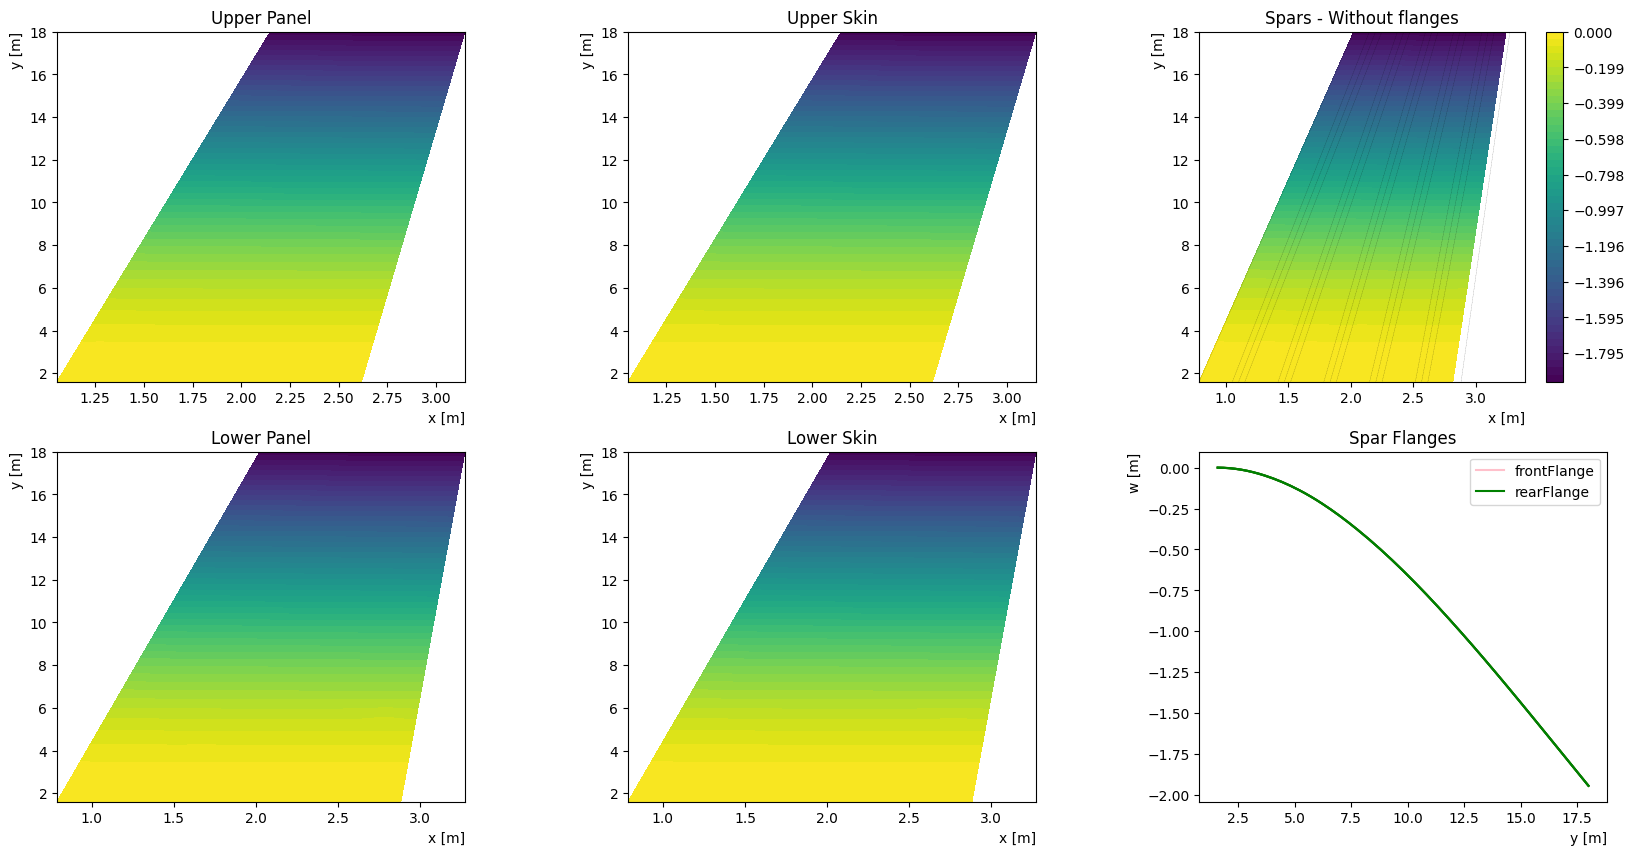

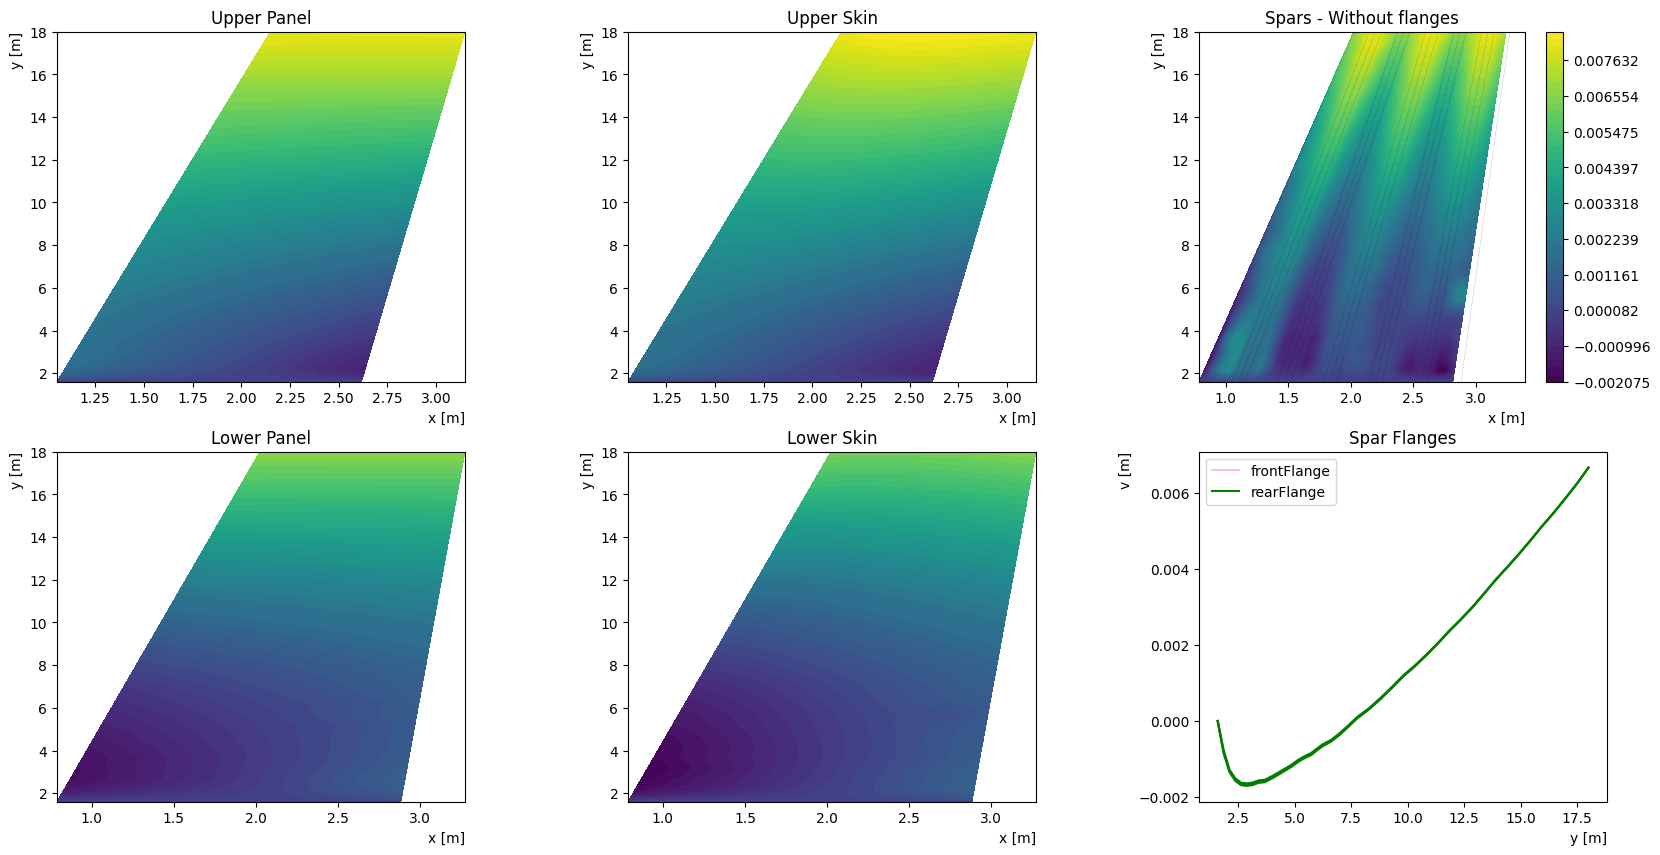

In [5]:
'''Standard deflection plots to check the solution's quality'''
wfig = bl.plot_block(sol['w'], "w", meshOut, csts)
vfig = bl.plot_block(sol['v'], "v", meshOut, csts)

# Post Processor - internal forces and margins for every failure mode

In [6]:
'''COPYPASTE THIS TO blocks.py ONCE DONE!!!'''
def post_processor_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object]):
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOuts["N"])
    u, bu, bk = tuple(defl[k] for k in ["u", "bu", "bk"])
    #only for quads and beams as of now - that's all we are using
    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_xe(ncoords_flatten)
        quad.update_probe_ue(u)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)
    for beam in eleDict["beam"]:
        beam.update_probe_xe(ncoords_flatten)
        beam.update_probe_ue(u)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop)
    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]
    fi[bk] = 0 #to avoid internal force at clamps which can be latge and are weirdly defined

    return {"elements":eleDict, "fi":fi, "KG":KG, "KGuu":KGuu}

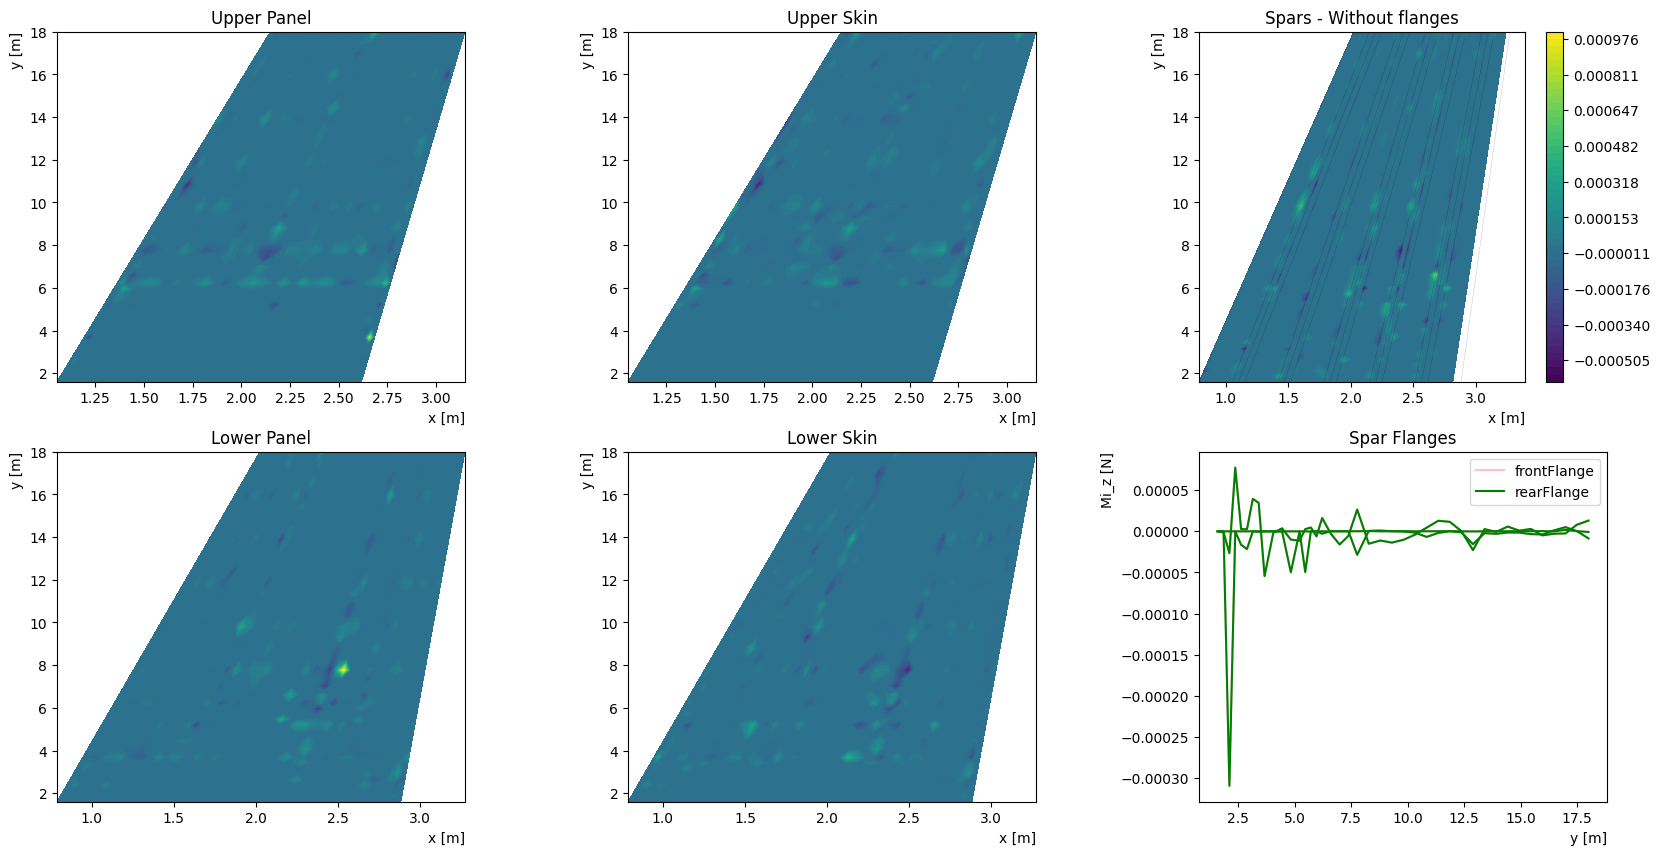

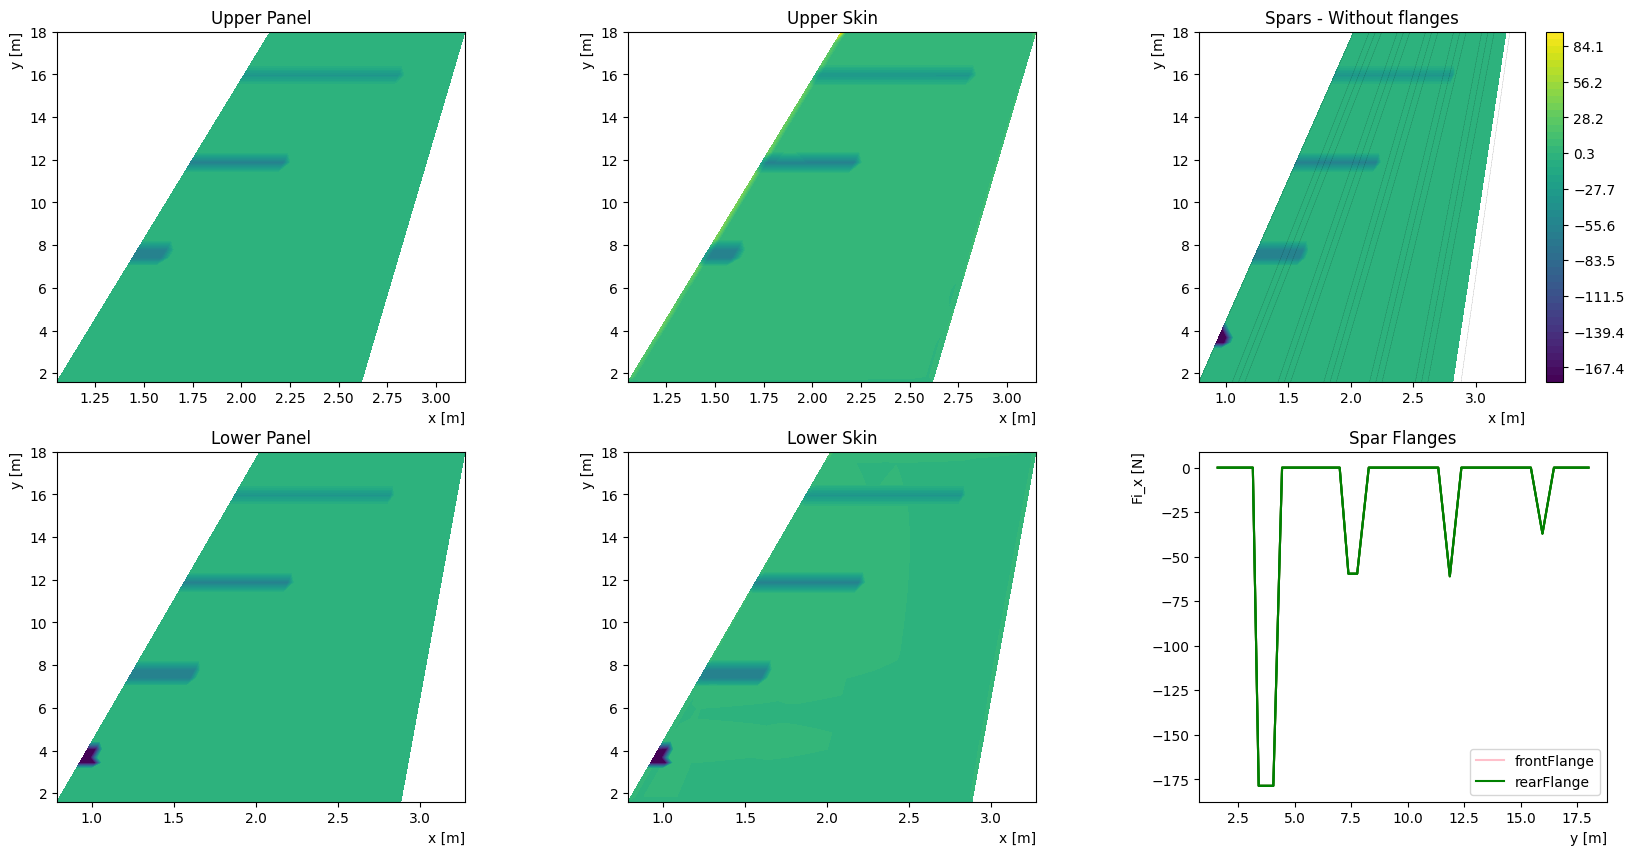

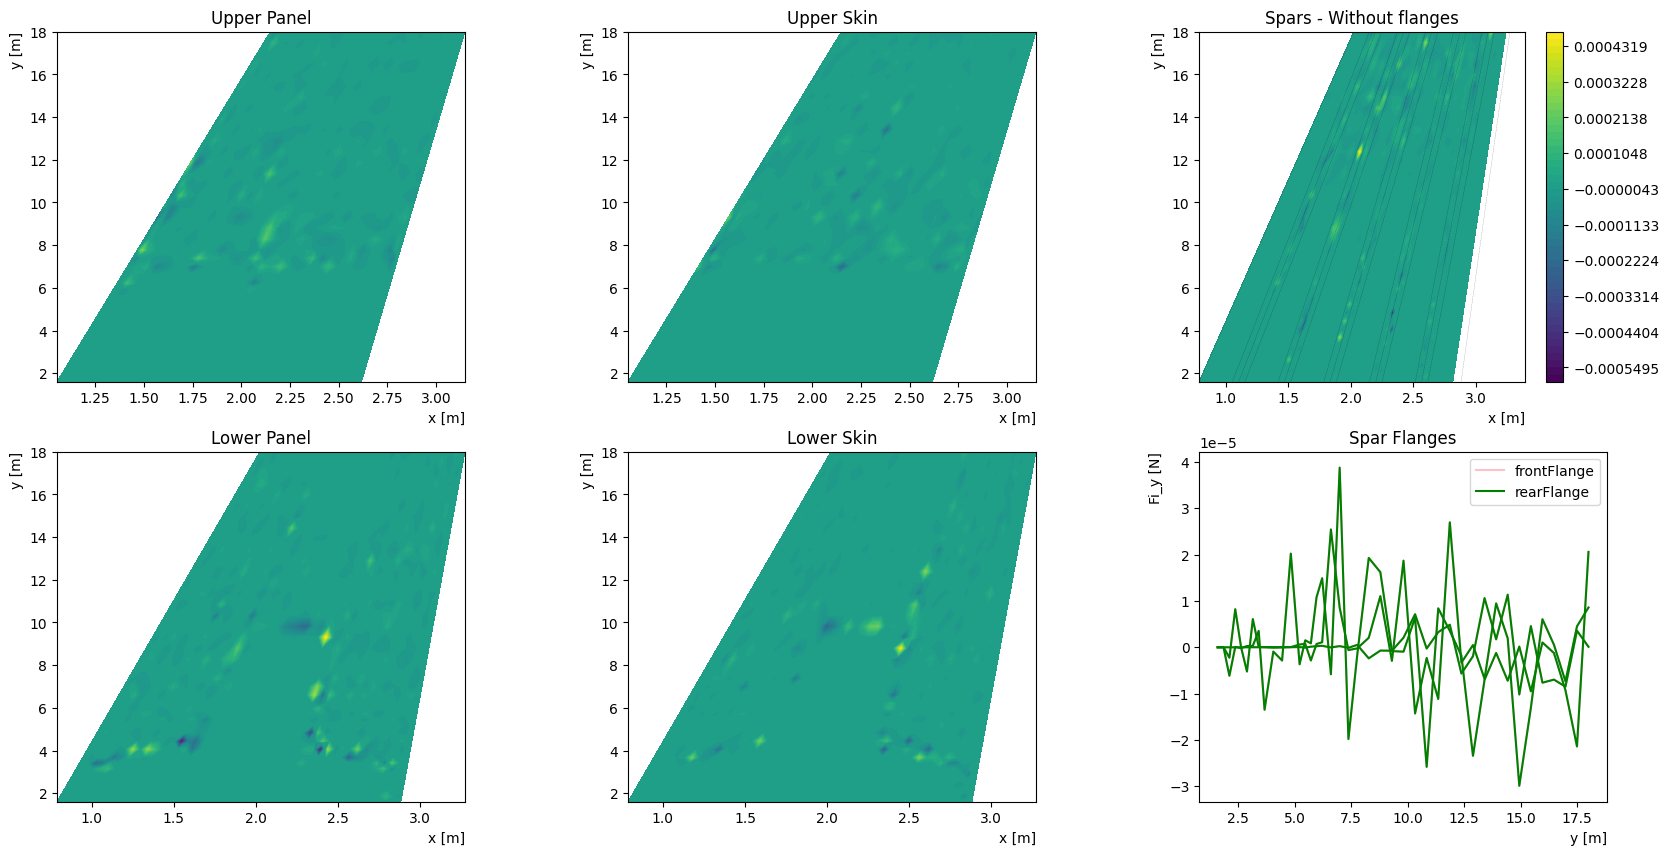

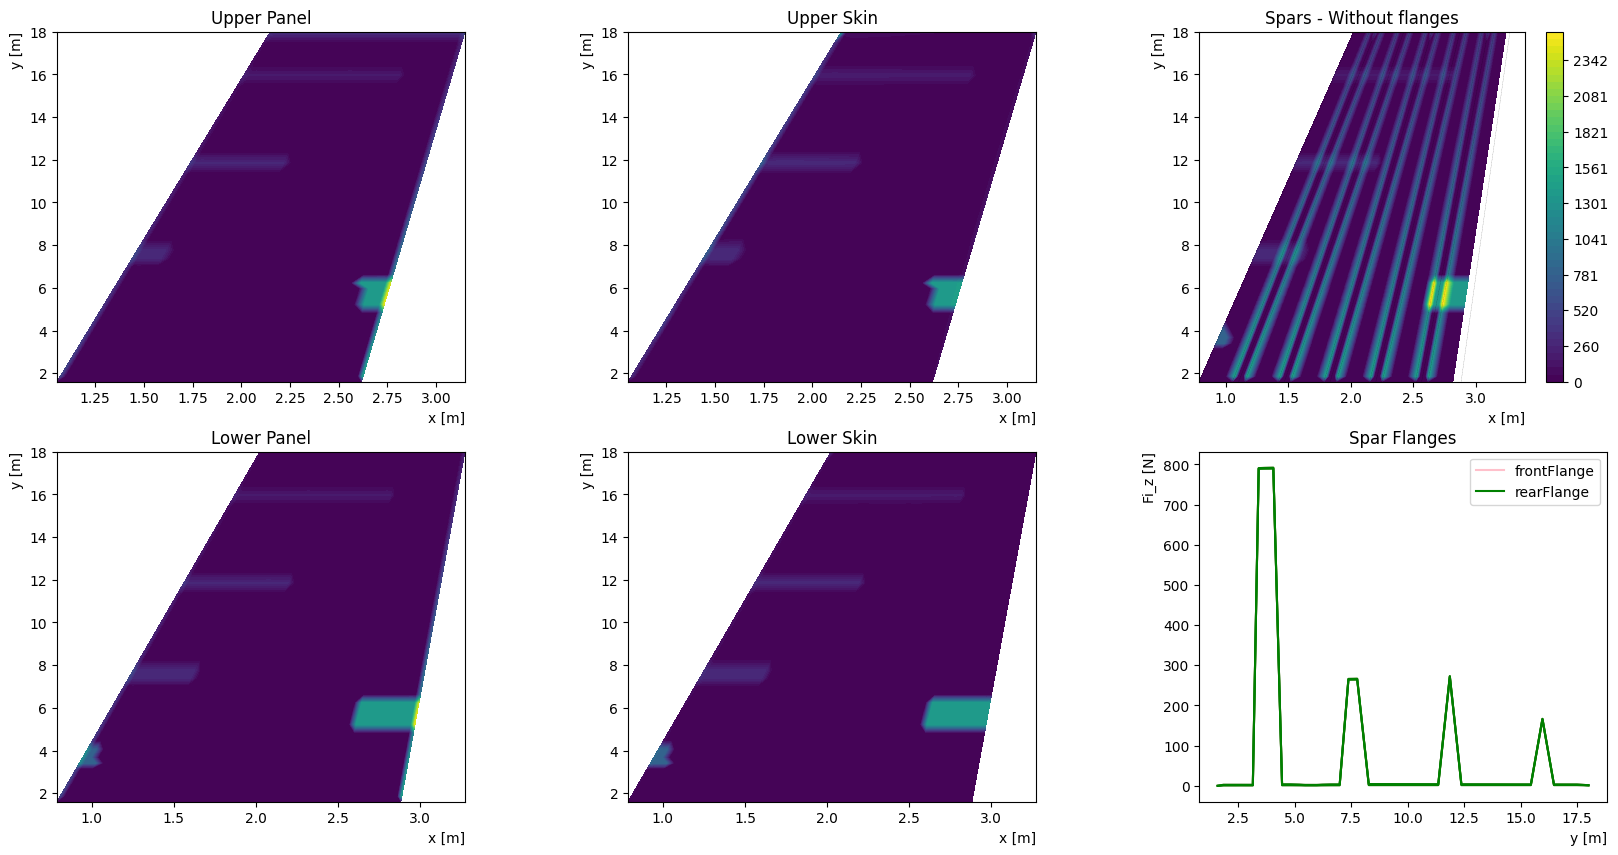

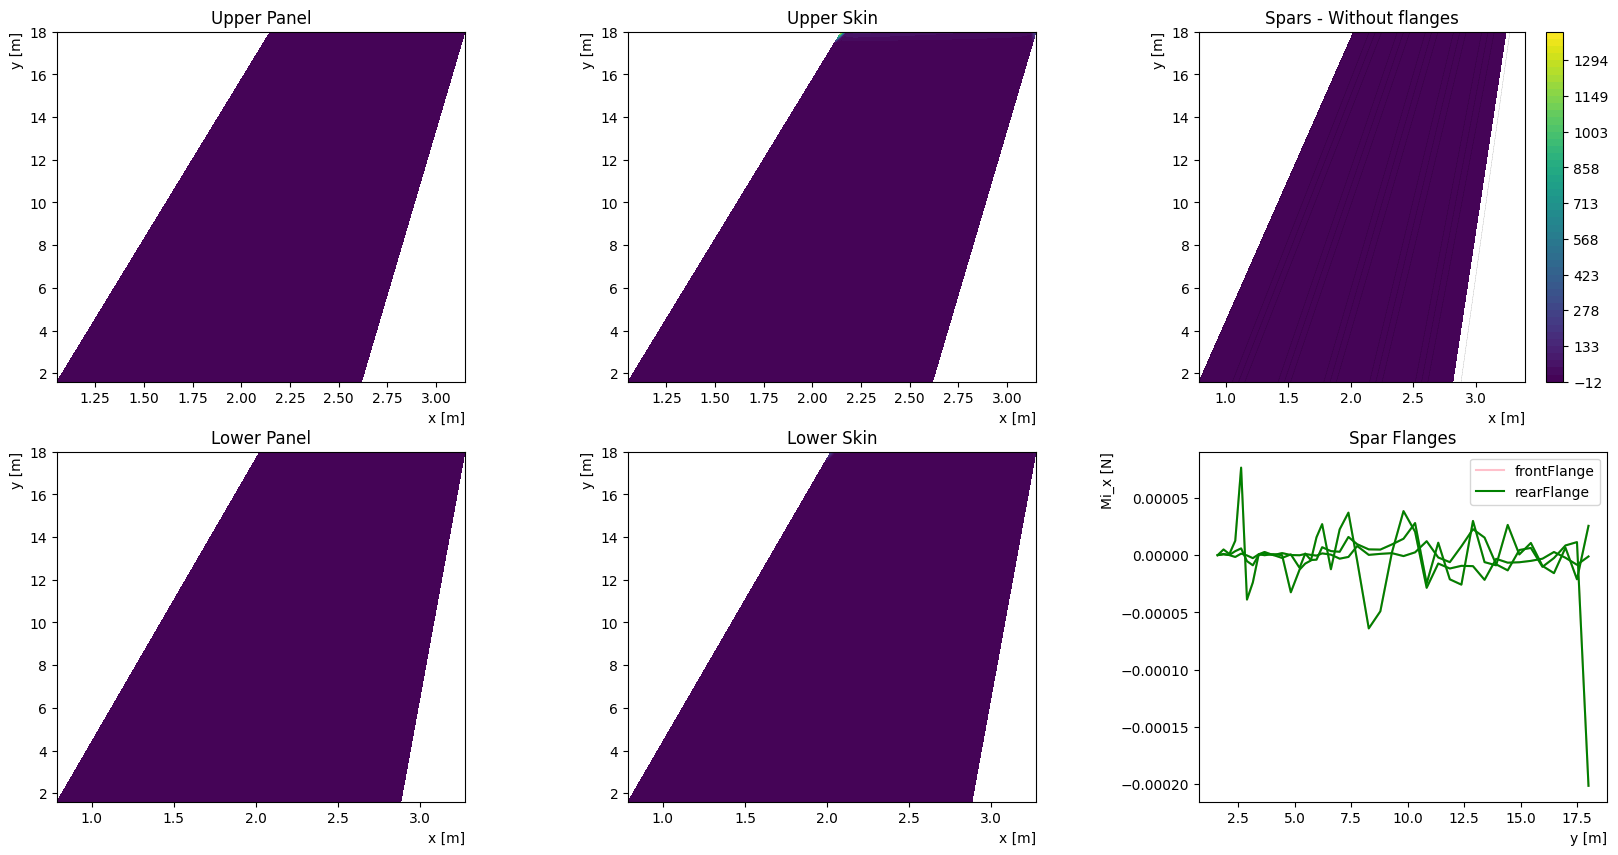

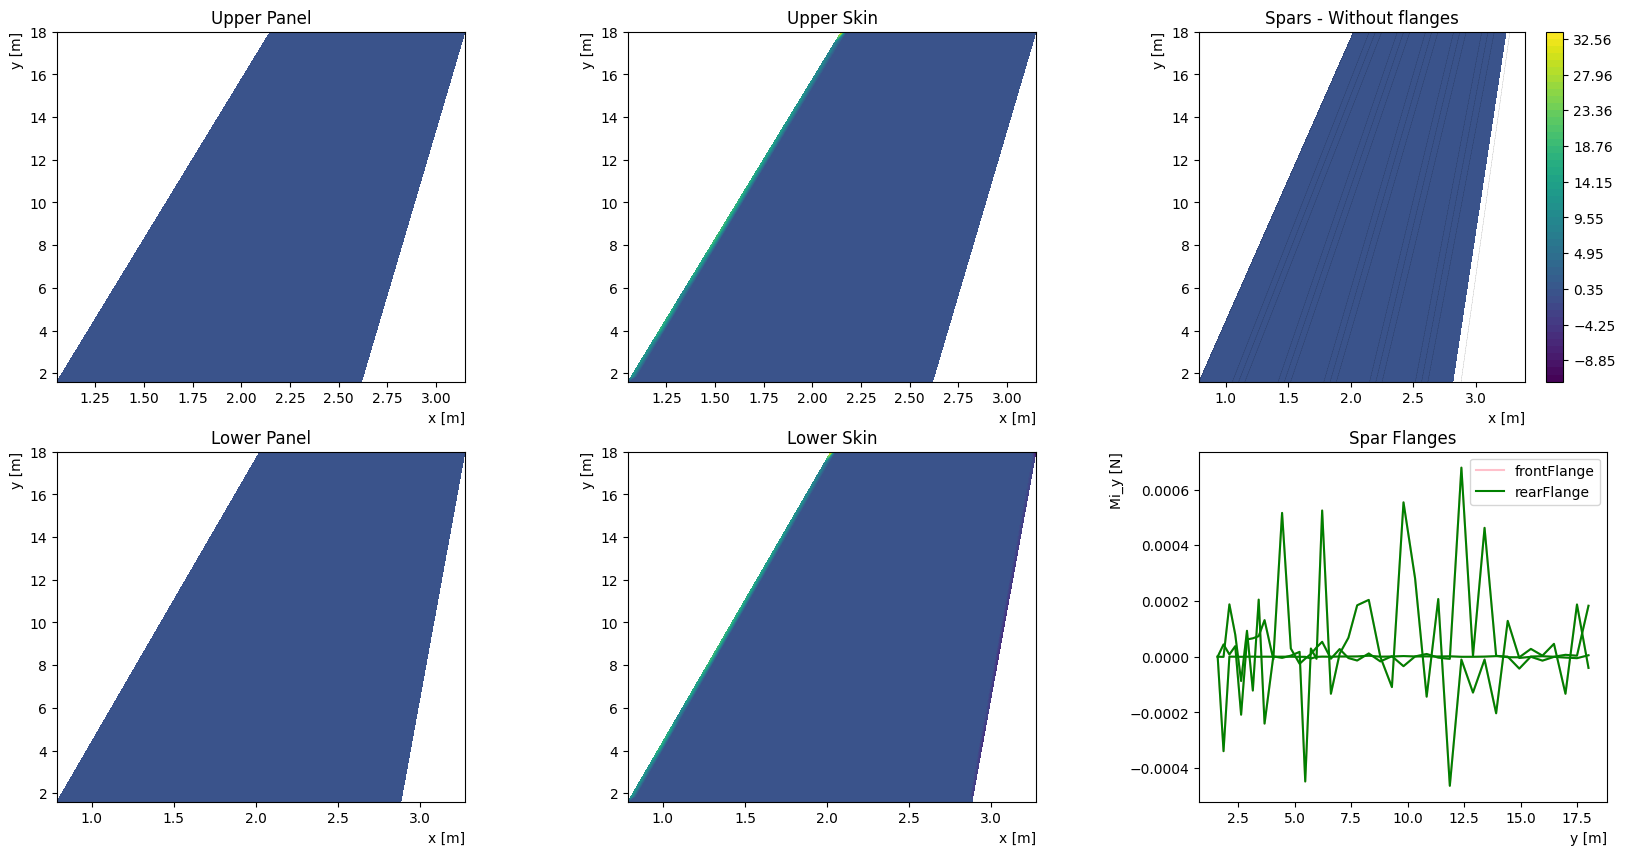

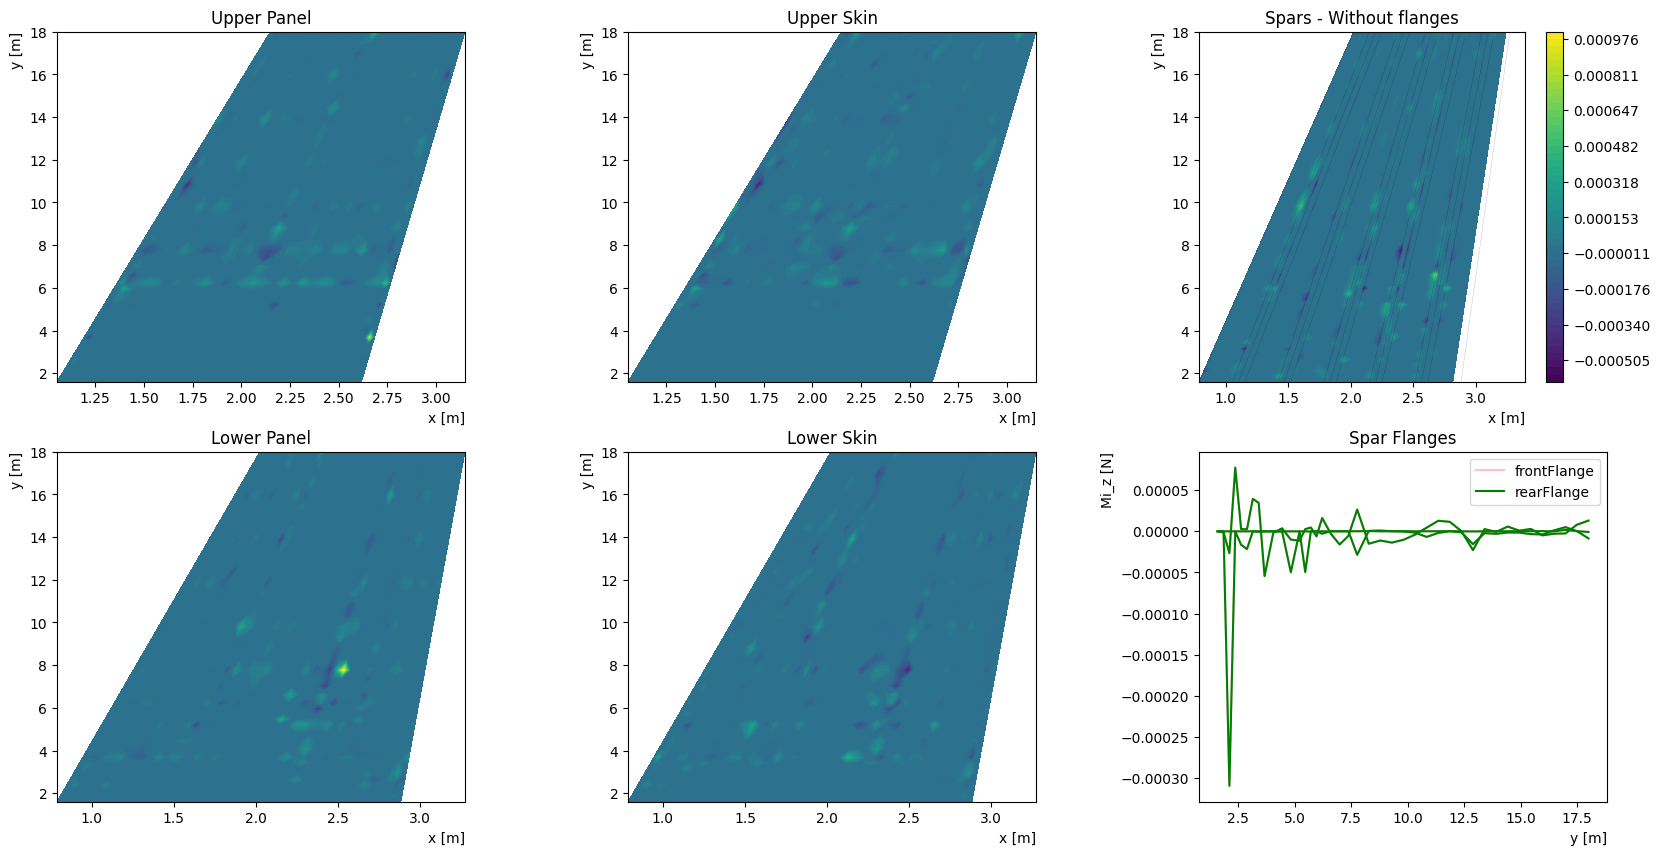

In [19]:
ppd = post_processor_block(sol, meshOut)
bl.plot_block(ppd["fi"][0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["fi"][5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")